In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

### Tutorial B3: Spacing

> predict + ersatz (multisubstitute) + predict

Although marginalization experiments can be invaluable in identifying the influence that one motif (or larger construct) has by itself, sometimes one wishes to investigate the influence that multiple motifs have and how this changes as spacings between them change. Specifically, one might want to see how model predictions change as two motifs are moved closer or further apart from each other. Given enough compute, one might even want to comprehensively look at how all pairs or sets of motifs influence predictions as they are spaced differently!

`tangermeme` implements this functionality in the `space` function, which is conceptually similar to the `marginalize` function except that it takes in a set of motifs and the respective spacing between them. Conceptually, the difference between `marginalize` and `space` is the difference between the `substitute` and the `multisubstitute` functions, where `marginalize` just substitutes in a given motif but `space` has to handle the bookkeeping of where precisely to substitute motifs given a set of motifs of different lengths and their spacings. 

#### Space

The basic functionality implemented in spacing experiments is the insertion of multiple motifs at a given spacing paired with predictions before and after the insertion. Accordingly, the signature is very similar to that of `marginalize` except that a list of motifs are passed in alongside either one or more values corresponding to the spacing. Predictions are made before and after the motifs are inserted and returned.

Let's show an example using the Beluga/DeepSEA model.

In [2]:
import torch
from model import Beluga

model = Beluga()
model.load_state_dict(torch.load("deepsea.beluga.torch"))

Beluga(
  (model): Sequential(
    (0): Sequential(
      (0): Conv2d(4, 320, kernel_size=(1, 8), stride=(1, 1))
      (1): ReLU()
      (2): Conv2d(320, 320, kernel_size=(1, 8), stride=(1, 1))
      (3): ReLU()
      (4): Dropout(p=0.2, inplace=False)
      (5): MaxPool2d(kernel_size=(1, 4), stride=(1, 4), padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(320, 480, kernel_size=(1, 8), stride=(1, 1))
      (7): ReLU()
      (8): Conv2d(480, 480, kernel_size=(1, 8), stride=(1, 1))
      (9): ReLU()
      (10): Dropout(p=0.2, inplace=False)
      (11): MaxPool2d(kernel_size=(1, 4), stride=(1, 4), padding=0, dilation=1, ceil_mode=False)
      (12): Conv2d(480, 640, kernel_size=(1, 8), stride=(1, 1))
      (13): ReLU()
      (14): Conv2d(640, 640, kernel_size=(1, 8), stride=(1, 1))
      (15): ReLU()
    )
    (1): Sequential(
      (0): Dropout(p=0.5, inplace=False)
      (1): Lambda()
      (2): Sequential(
        (0): Lambda()
        (1): Linear(in_features=67840, out_features

Then, we can generate some random sequence. Just like when running marginalizations, the choice of background sequence is important and simply using uniform random sequence (like we do here) will likely be suboptimal. However, it is a simple background to implement, so we'll use it here.

In [3]:
from tangermeme.utils import random_one_hot

X = random_one_hot((100, 4, 2000)).type(torch.float32)  # Generate 100 random sequences to marginalize over

Now, we just need a motif to add in. We can start off with adding in two AP-1 motifs.

In [4]:
from tangermeme.space import space

y_before, y_after = space(model, X, ["CTCAGTGATG", "CTCAGTGATG"], spacing=10, device='cpu')
y_before.shape, y_after.shape

(torch.Size([100, 2002]), torch.Size([100, 2002]))

This will add two motifs in with a spacing of 10 between them. By default, the range from the start of the first motif to the end of the last motif (including the spacing between the motifs) will be substituted into the center of the sequence. Characters that reside in the spacing between the motifs are left as-is. If `start` is provided, the first character of the first motif is inserted at that position and the rest of the sequence proceeds from there.

First, we can check that adding in the AP-1 motifs increased the predicted value for a task involving an AP-1 factor.

In [5]:
y_before.mean(axis=0)[267], y_after.mean(axis=0)[267]

(tensor(-3.7841), tensor(-0.5900))

Looks like the logit increased quite a bit, as we might expect.

Next, we can look at how changing the spacing between these motifs changes the predicted value to see if there is some sort of synergeistic effect between the two motifs.

In [6]:
yb, ya = [], []

for i in range(0, 50):
    y_before, y_after = space(model, X, ["CTCAGTGATG", "CTCAGTGATG"], spacing=i, device='cpu')
    
    yb.append(y_before.mean(axis=0)[267])
    ya.append(y_after.mean(axis=0)[267])

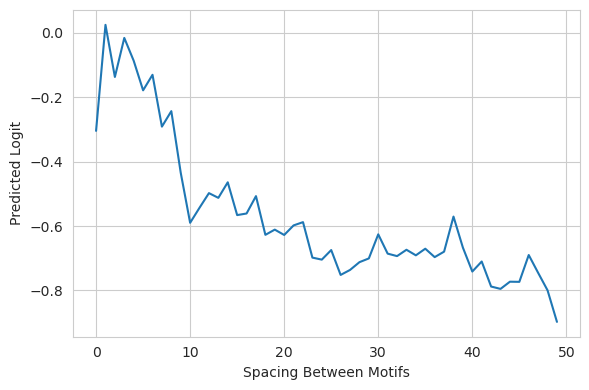

In [7]:
from matplotlib import pyplot as plt
import seaborn; seaborn.set_style('whitegrid')

plt.figure(figsize=(6, 4))
plt.plot(ya)

plt.xlabel("Spacing Between Motifs", fontsize=10)
plt.ylabel("Predicted Logit")
plt.tight_layout()
plt.show()

It looks like there may be some sort of synergy between the two motifs. As the motifs get further apart, the predicted logit from the model goes down. But, there also seems to be some sort of cyclic aspect to it where every few basepairs the predicted probability increases before then continuing to decrease. This is potentially due to the shape of the DNA playing a role in binding -- where every half turn (around 6-7 bp) there is a complementary effect.

If we have more than two motifs we can just pass in a longer list.

In [8]:
y_before, y_after = space(model, X, ["CTCAGTGATG", "CTCAGTGATG", "CTCAGTGATG"], spacing=10, device='cpu')
y_before.mean(axis=0)[267], y_after.mean(axis=0)[267]

(tensor(-3.7841), tensor(0.6950))

Looks like having a third motif does increase binding by a little bit.

Passing in an integer for `spacing` means that each motif has the same spacing from the previous motif. However, sometimes we might want to change the spacing between different motifs so that we can investigate the spacing effects separately. In that case, we can pass in a list with one fewer elements than the list of motifs. In this list, the integers represent the spacing between the respective motif and the next motif in the list.

In [9]:
y_before, y_after = space(model, X, ["CTCAGTGATG", "CTCAGTGATG", "CTCAGTGATG"], spacing=[4, 10], device='cpu')
y_before.mean(axis=0)[267], y_after.mean(axis=0)[267]

(tensor(-3.7841), tensor(0.9881))

Naturally, the motifs do not have to be the same. If you want to investigate the role that different motifs have across spacings, this function is perfect.

In [10]:
y_before, y_after = space(model, X, ["CTCAGTGATG", "ACATTG", "ATAGA"], spacing=[4, 10], device='cpu')
y_before.mean(axis=0)[267], y_after.mean(axis=0)[267]

(tensor(-3.7841), tensor(-2.2778))

We can see that only adding in one AP-1 motif, and two gibberish motifs, causes the predictions to only increase modestly. This modest increase makes sense because the previous instances had multiple copies of that motif. We can confirm that there isn't some weird effect being learned by checking the predictions as we change the spacing between the AP-1 motif and the other pseudomotifs there.

In [11]:
yb, ya = [], []

for i in range(0, 50):
    y_before, y_after = space(model, X, ["CTCAGTGATG", "ACATTG", "ATAGA"], spacing=[i, 10], device='cpu')
    
    yb.append(y_before.mean(axis=0)[267])
    ya.append(y_after.mean(axis=0)[267])

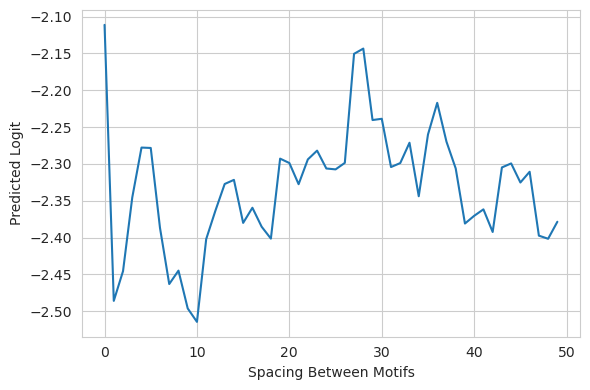

In [12]:
plt.figure(figsize=(6, 4))
plt.plot(ya)

plt.xlabel("Spacing Between Motifs", fontsize=10)
plt.ylabel("Predicted Logit")
plt.tight_layout()
plt.show()

We can see that, although there is some wiggling in the prediction as the distance between the first two motifs increases, the magnitude does not significantly change overall and the trendline is basically near zero. This confirms that there is not always a synergistic effect between motifs.
